In [2]:
%matplotlib inline

In [3]:
import numpy as np
np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
from scipy.signal import convolve
from tqdm import tqdm
import starry

In [4]:
def doppler_field(x, y, w=0.01, inc=90, alpha=0, cb=0):
    """
    The (log) Doppler field for the general case of
    a differentially-rotating star with convective 
    blueshift.

    """
    sini = np.sin(inc * np.pi / 180)
    cosi = np.cos(inc * np.pi / 180)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    beta = w * sini * x * (1 - alpha * (sini * y + cosi * z) ** 2) + z * cb
    return np.log(1 + beta)

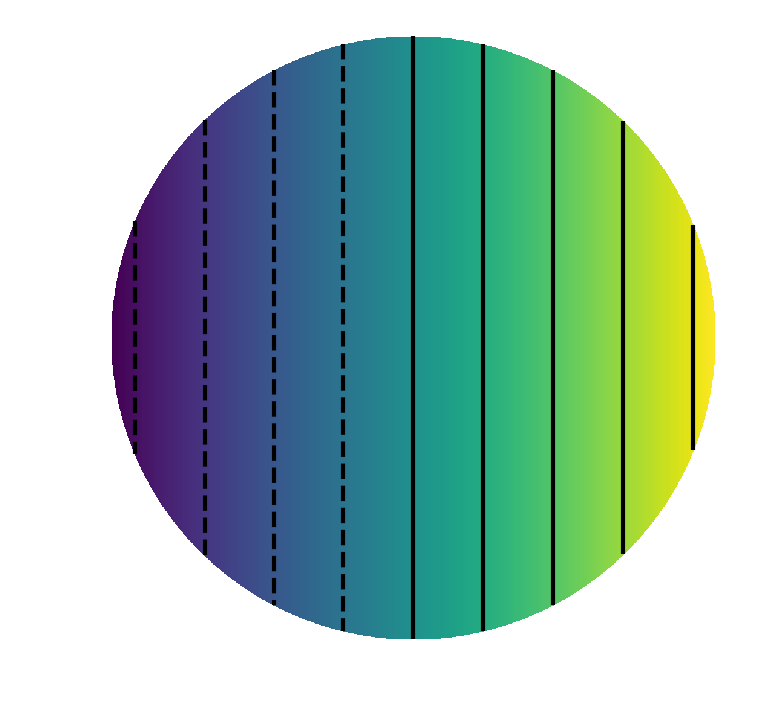

In [5]:
# Field parameters
w = 0.01
inc = 60
alpha = 0.25
cb = 0.0

# Plot the image
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x ** 2 - y ** 2)
fig, ax = plt.subplots(1)
D = doppler_field(x, y, w=w, inc=inc, alpha=alpha, cb=cb)
ax.imshow(D, origin="lower", extent=(-1, 1, -1, 1))
ax.contour(D, origin="lower", colors="k", extent=(-1, 1, -1, 1), levels=10);
ax.axis('off');

In [6]:
# Discretize the surface
res = 300
ydeg = 10
Ny = (ydeg + 1) ** 2
map = starry.Map(ydeg=ydeg, lazy=False)

x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
inside = x ** 2 + y ** 2 < 1
x = x[inside].flatten()
y = y[inside].flatten()
npts = len(x)

def Ylm(l, m):
    map.reset()
    if l != 0:
        map[l, m] = 1.0
        return map.intensity(x=x, y=y) - 1.0 / np.pi
    else:
        return map.intensity(x=x, y=y)

In [7]:
# Compute the Doppler field
D = doppler_field(x, y, w=w, inc=inc, alpha=alpha, cb=cb)

In [8]:
# Discretize the transform
ntau = 101 # This number *must* be odd!
max_tau = np.max(np.abs(D))
tau = np.linspace(-max_tau, max_tau, ntau)
dtau = tau[1] - tau[0]
bins = np.append(tau - 0.5 * dtau, [tau[-1] + 0.5 * dtau])

In [9]:
g = np.empty((Ny, ntau))
n = 0
for l in tqdm(range(ydeg + 1)):
    for m in range(-l, l + 1):
        g[n], _ = np.histogram(D, weights=Ylm(l, m) * ntau / npts, bins=bins)
        n += 1

100%|██████████| 11/11 [00:03<00:00,  2.73it/s]


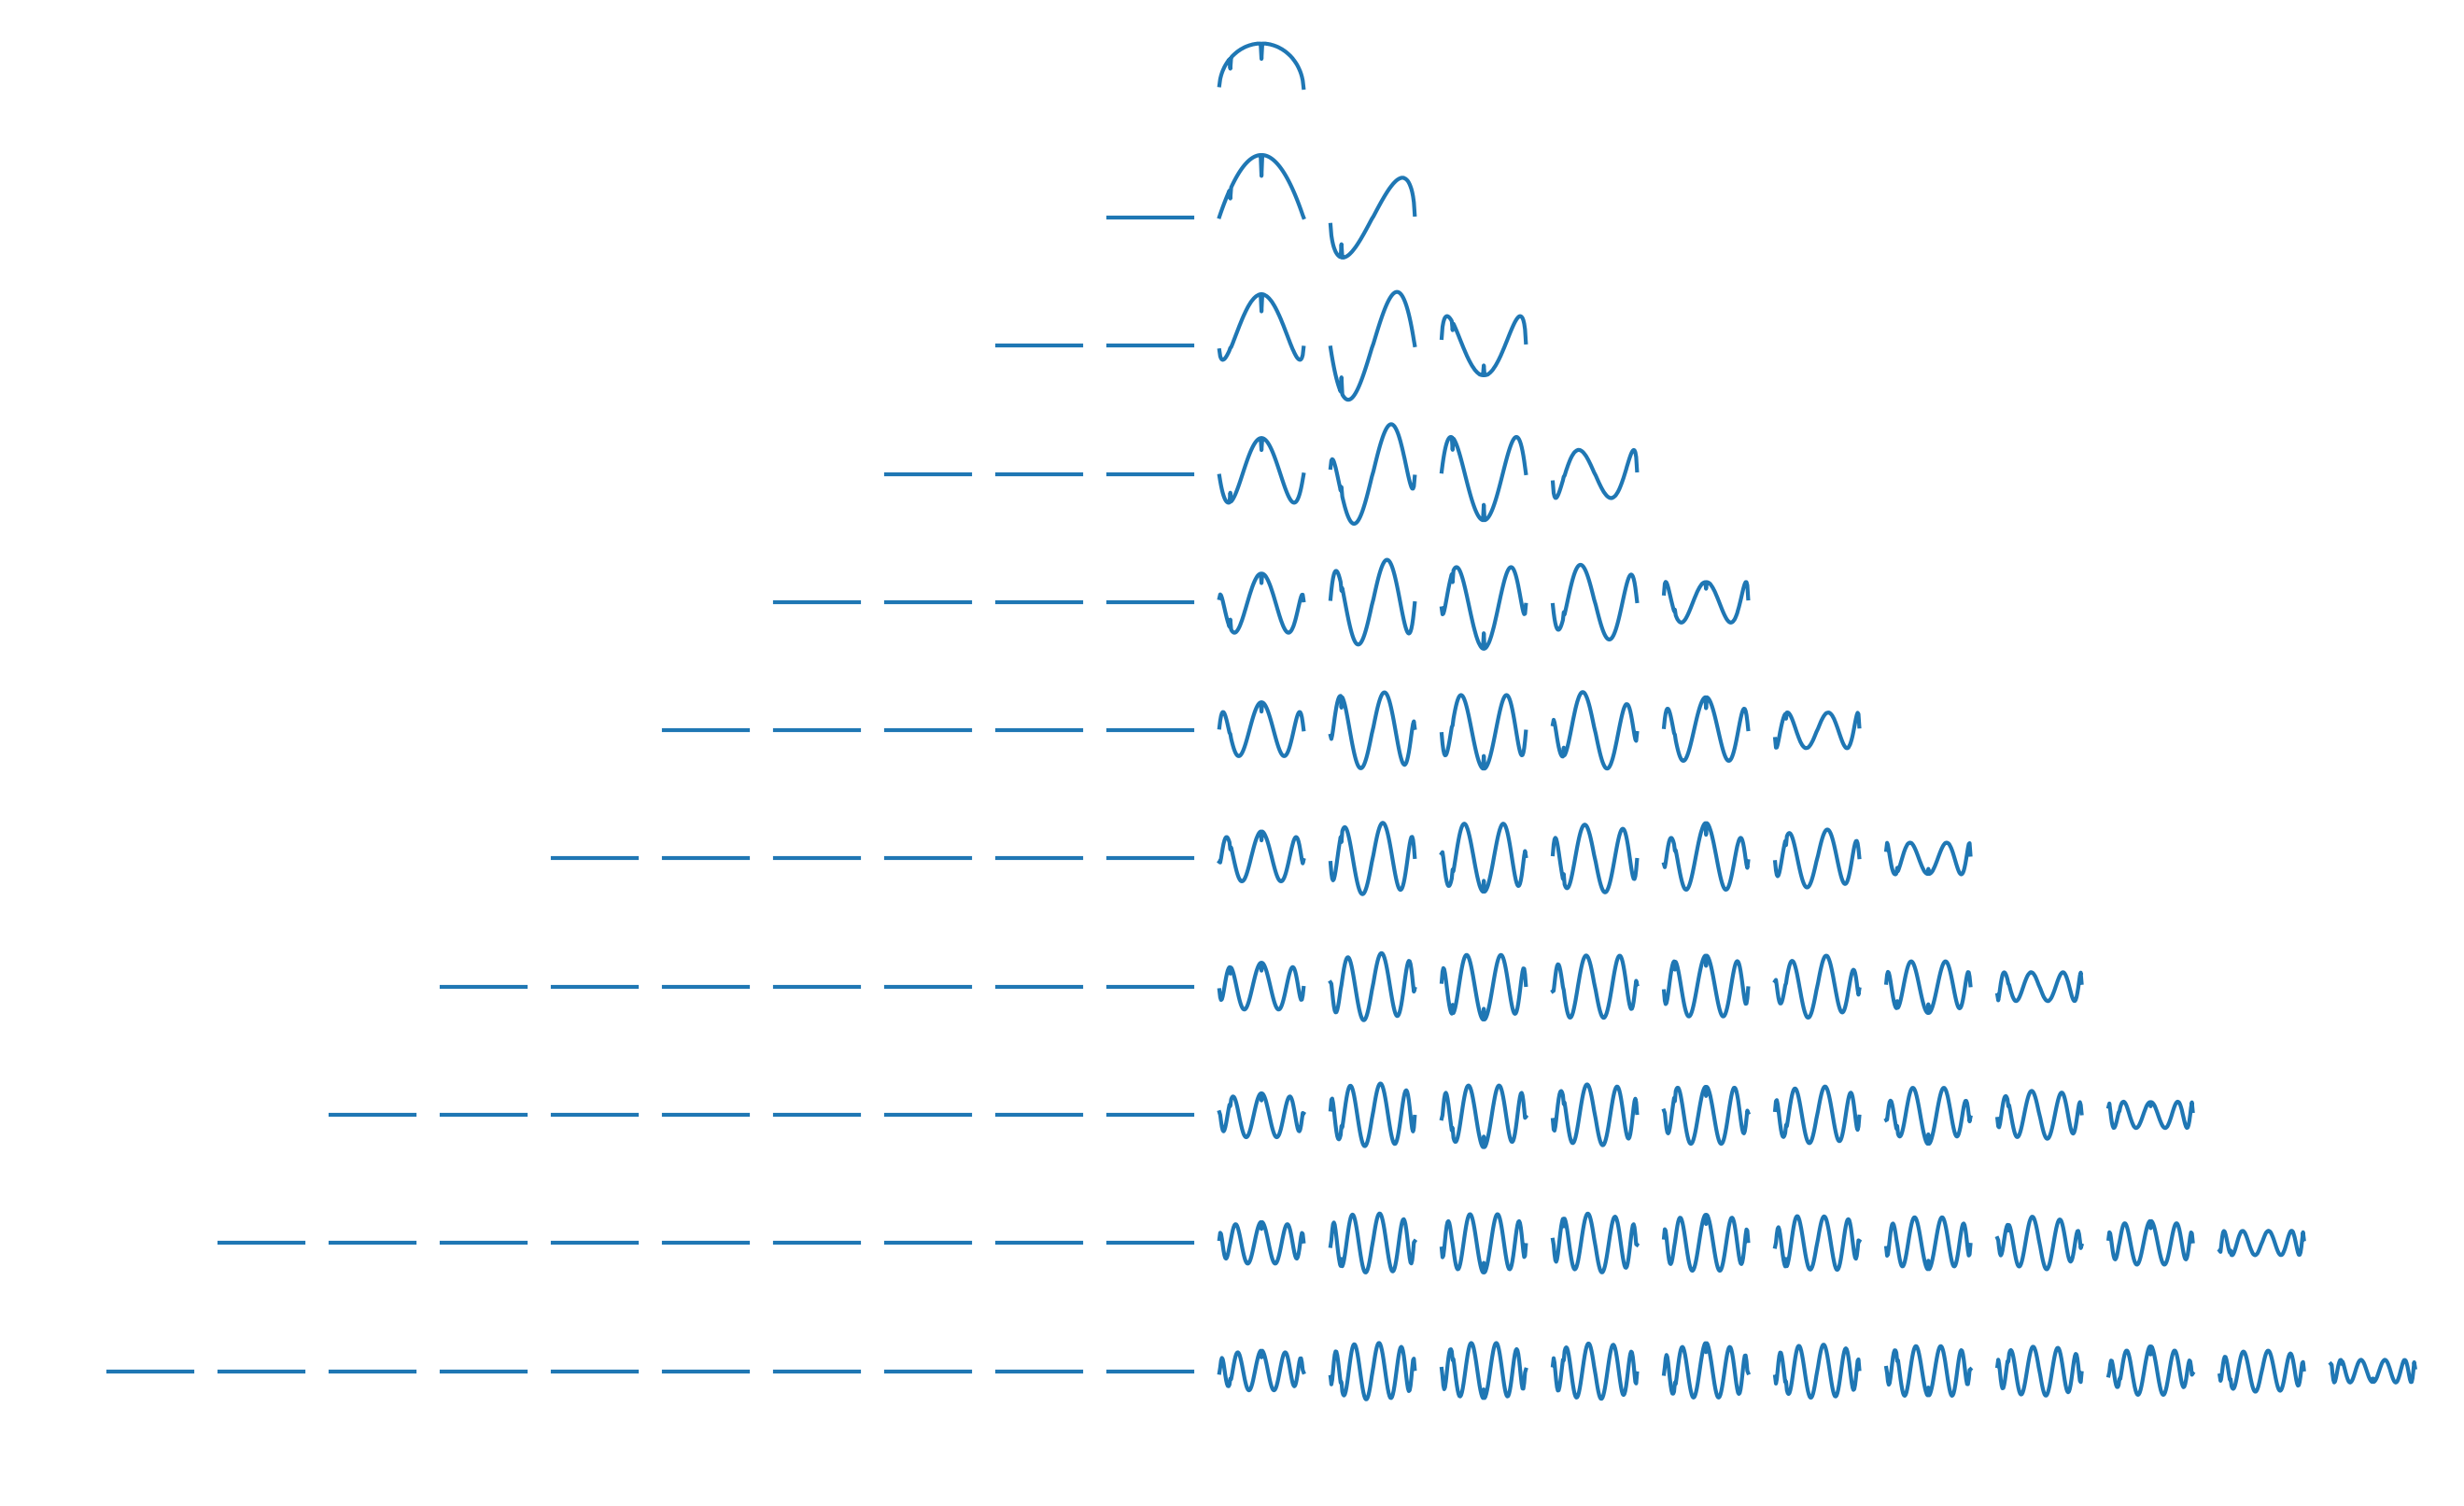

In [10]:
# Set up the plot
fig, ax = plt.subplots(ydeg + 1, 2 * ydeg + 1, figsize=(16, 10), 
                       sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
for axis in ax.flatten():
    axis.axis('off')

# Loop over the orders and degrees
n = 0
for i, l in enumerate(range(ydeg + 1)):
    for j, m in enumerate(range(-l, l + 1)):

        # Offset the index for centered plotting
        j += ydeg - l

        # Compute the spherical harmonic
        ax[i, j].plot(g[n])
        
        n += 1

In [21]:
# Get the map image at a given phase
map = starry.Map(ydeg=ydeg, lazy=False)
map.add_spot(amp=-0.25, sigma=0.05, lat=30, lon=30)
map.inc = 60
map.align([0, 1, 0])
alm = np.array(map.y)

Compiling `add_spot`... Done.
Compiling `get_axis`... Done.
Compiling `align`... Done.


Compiling `render`... Done.


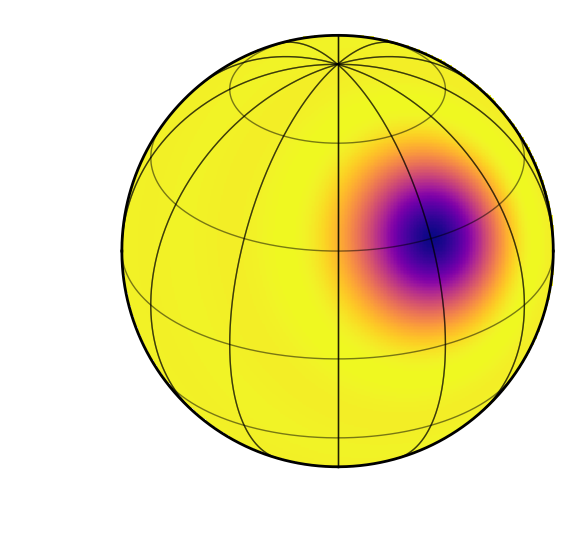

In [22]:
map.show()

In [23]:
# Define a base spectrum
xi = np.arange(-5 * max_tau, 5 * max_tau, dtau)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 2.5 * max_tau
amp = 1.0
mu = 0.0
sigma = 0.1 * max_tau
I0 = 1 - amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)

In [24]:
# Starry
a = np.dot(alm.reshape(-1, 1), I0.reshape(1, -1))
S = np.zeros_like(xi)
for n in range(Ny):
    S += convolve(a[n], g[n], mode="same")
S /= S[obs][0]

In [25]:
# Numerical
res = 100
image = np.tile(map.render(res=res).reshape(-1, 1), len(xi))
x, y, z = map.ops.compute_ortho_grid(res).eval()
D = doppler_field(x, y, w=w, inc=inc, alpha=alpha, cb=cb)
spec = np.interp(xi - D.reshape(-1, 1), xi, I0)
Snum = np.nansum(image * spec, axis=0)
Snum /= Snum[0]

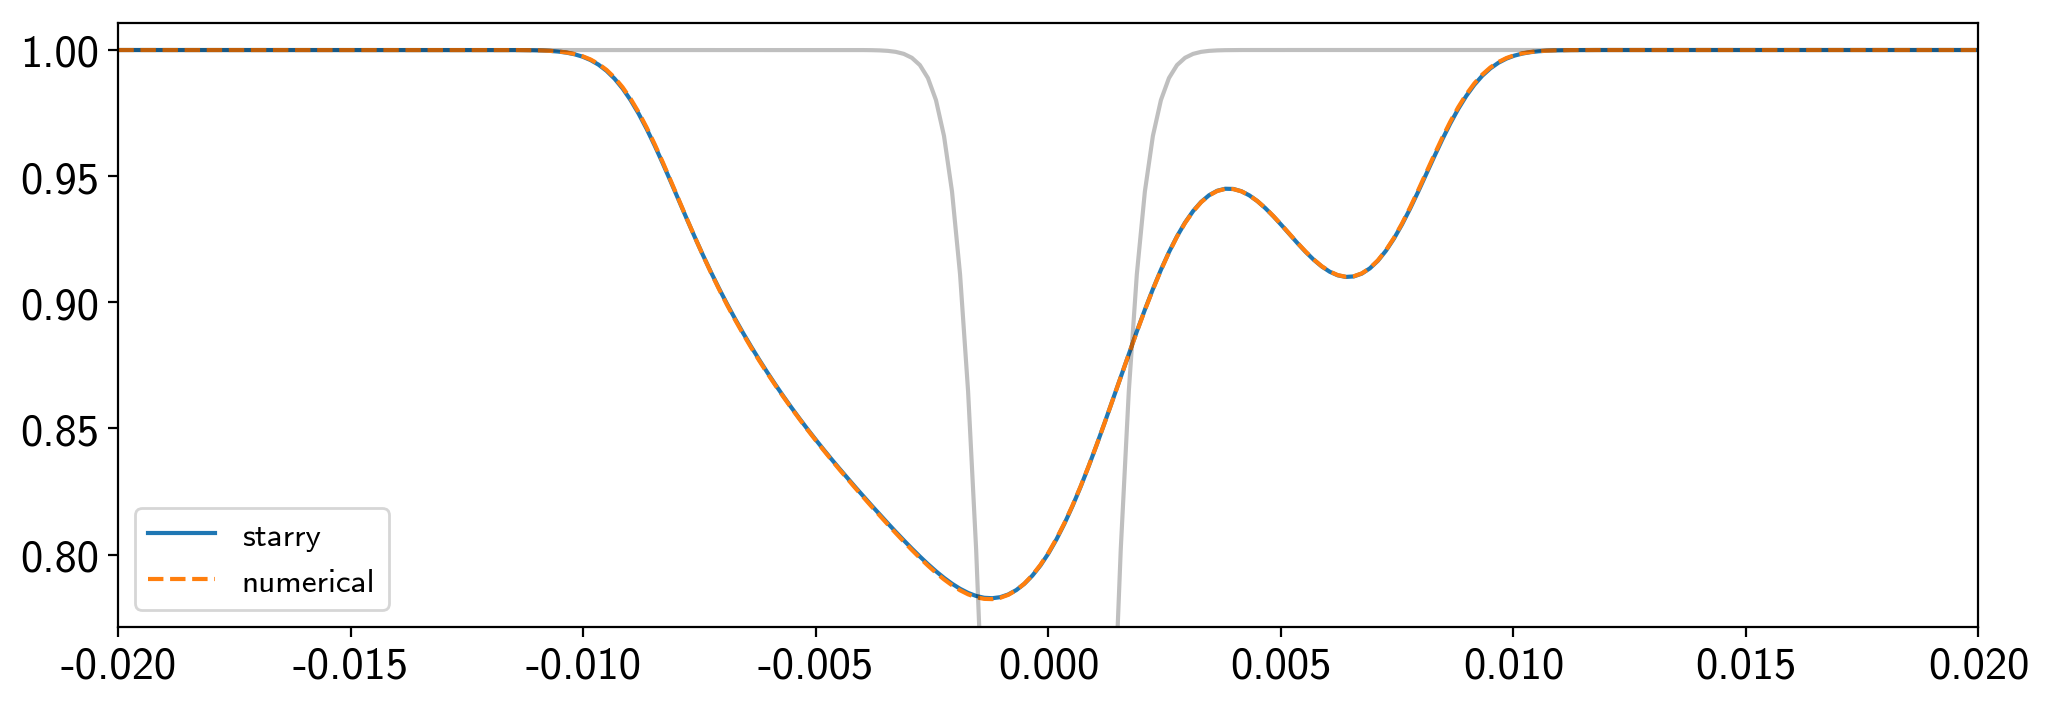

In [26]:
plt.plot(xi[obs], S[obs], label="starry");
plt.plot(xi[obs], Snum[obs], "--", label="numerical");
plt.gca().set_ylim(*plt.gca().get_ylim())
plt.gca().set_xlim(-0.02, 0.02)
plt.plot(xi[obs], I0[obs], "k-", alpha=0.25);
plt.legend(fontsize=12);

In [27]:
# Starry
map = starry.Map(ydeg=ydeg, lazy=False)
map.add_spot(amp=-0.25, sigma=0.05, lat=30, lon=0)
map.inc = 60
map.align([0, 1, 0])
ntheta = 100 
S = np.zeros((ntheta, len(xi)))
for k in range(ntheta):
    map.rotate(360.0 / ntheta)
    a = np.dot(map.y.reshape(-1, 1), I0.reshape(1, -1))
    for n in range(Ny):
        S[k] += convolve(a[n], g[n], mode="same")
    S[k] /= S[k][obs][0]

Compiling `add_spot`... Done.
Compiling `get_axis`... Done.
Compiling `align`... Done.
Compiling `rotate`... Done.


In [28]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, figsize=(10, 6))

line, = ax.plot(xi[obs], S[0][obs])
ax.set_xlim(xi[obs][0], xi[obs][-1])
ax.set_ylim(0.75, 1.05)

ax_map = inset_axes(ax, width="20%", height="50%", loc=4, borderpad=1)
img = map.render(res=50, theta=np.linspace(0, 360, ntheta))
viz = ax_map.imshow(img[:, :, 0], origin="lower", cmap="plasma")
ax_map.axis('off');

def updatefig(i):
    line.set_ydata(S[i][obs])
    viz.set_data(img[:, :, i])
    return line, viz

ani = FuncAnimation(fig, updatefig, interval=100,
                    blit=False, frames=ntheta)

plt.close()
display(HTML(ani.to_jshtml()))

Compiling `render`... Done.
